# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов.\
В нём можно быстро узнать рыночную стоимость своего автомобиля.\
В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

## Задача

Построить модель для определения стоимости автомобиля.

Заказчику важны:
- качество предсказания, RMSE должно быть меньше 2500
- скорость предсказания
- время обучения

## 1. Загрузка данных

### 1.1 Импорт необходимых для работы библиотек, метрик и утилит

In [1]:
# !pip install skimpy

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# импорт моделей
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# предварительная обработка
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)

# метрики
from sklearn.metrics import mean_squared_error

# настройки
import warnings
warnings.filterwarnings("ignore")
from skimpy import clean_columns

# константа верхний регистр
RANDOM_STATE = 42

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Хорошее оформление импортов! \
Импорты собраны в одной ячейке, разделены на функциональные группы пустой строкой.</font>

### 1.2 Загрузка данных

In [3]:
# загрузим данные
data_avto = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\autos.csv')

#### Описание данных
 
**Признаки**
- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **Repaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя

**Целевой признак**
- **Price** — цена (евро)

### 1.3 Изучим данные в таблице

In [4]:
# функция для получения общей информации о данных
def get_info(data):
    display(data.head())
    display(data.tail())
    data.info()
    display(data.describe())
    print('\nРазмер таблицы:', data.shape)
    print('\nКоличество явных дубликатов:', data.duplicated().sum())
    print('\nКоличество пропусков в таблице:', data.isna().sum().sum())

In [5]:
# общая информация о данных
get_info(data_avto)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Размер таблицы: (354369, 16)

Количество явных дубликатов: 4

Количество пропусков в таблице: 181077


#### Выводы

1. Много пропусков
2. Дубликатов мало, можно удалить 
3. Приведем название столбцов к snake стилю
4. Есть явные аномалии в числовых признаках
5. Есть избыточные для обучения модели признаки, их можно удалить

### 1.4 Очистка данных

#### Удалим дубликаты

In [6]:
# удалим дубликаты и сохраним в новую таблицу
df = data_avto.drop_duplicates()

#### Удалим признаки, которые не влияют на стоимость автомобиля
- **DateCrawled** — дата скачивания анкеты из базы
- **RegistrationMonth** — месяц регистрации автомобиля
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя

In [7]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'],axis = 1)

In [8]:
# смотрим дубликаты
data_avto[data_avto.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [9]:
# полные копии, 4 строки, думаю, можно удалить
data_avto[data_avto.duplicated (keep='last')]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54


#### Приведем названия столбцов в нижний регистр

In [10]:
# переведем названия столбцов в snake стиль с помощью функции clean_columms из Skimpy
df = clean_columns(df)
df.columns.tolist()

10 column names have been cleaned

['price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'fuel_type',
 'brand',
 'repaired']

In [11]:
# оценим результ
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### 1.5 Обработаем числовые признаки

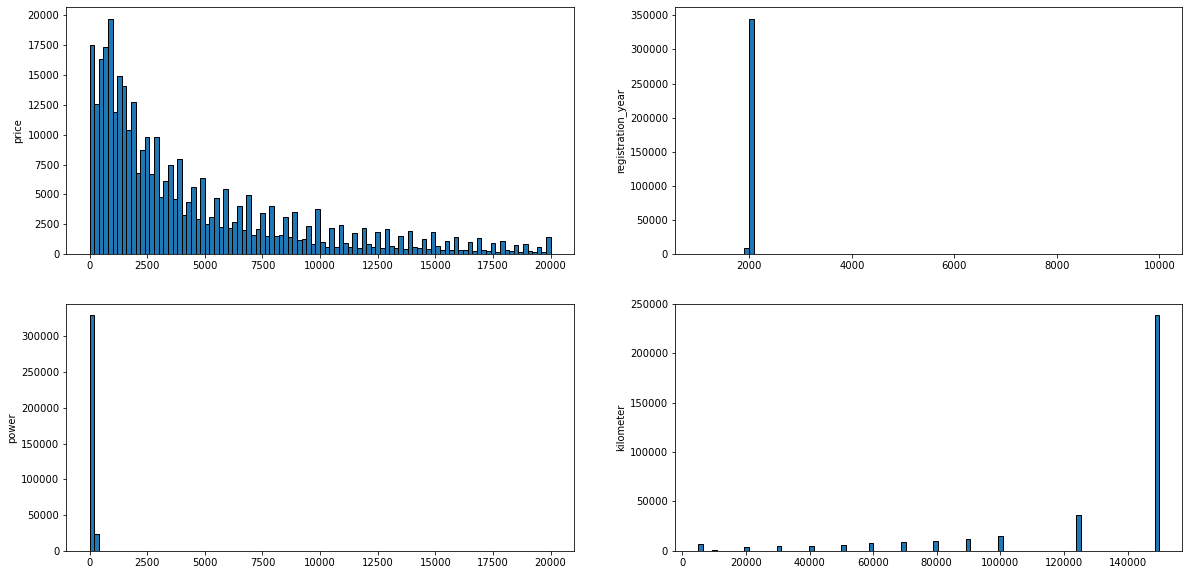

In [12]:
# отобразим числовые данные на графиках 

fig, axis = plt.subplots(2,2, figsize=(20,10))

df['price'].plot.hist(ax=axis[0,0], edgecolor='black', linewidth=1, bins=100).set(ylabel='price');
df['registration_year'].plot.hist(ax=axis[0,1], edgecolor='black', linewidth=1, bins=100).set(ylabel='registration_year');
df['power'].plot.hist(ax=axis[1,0], edgecolor='black', linewidth=1, bins=100).set(ylabel='power');
df['kilometer'].plot.hist(ax=axis[1,1], edgecolor='black', linewidth=1, bins=100).set(ylabel='kilometer');

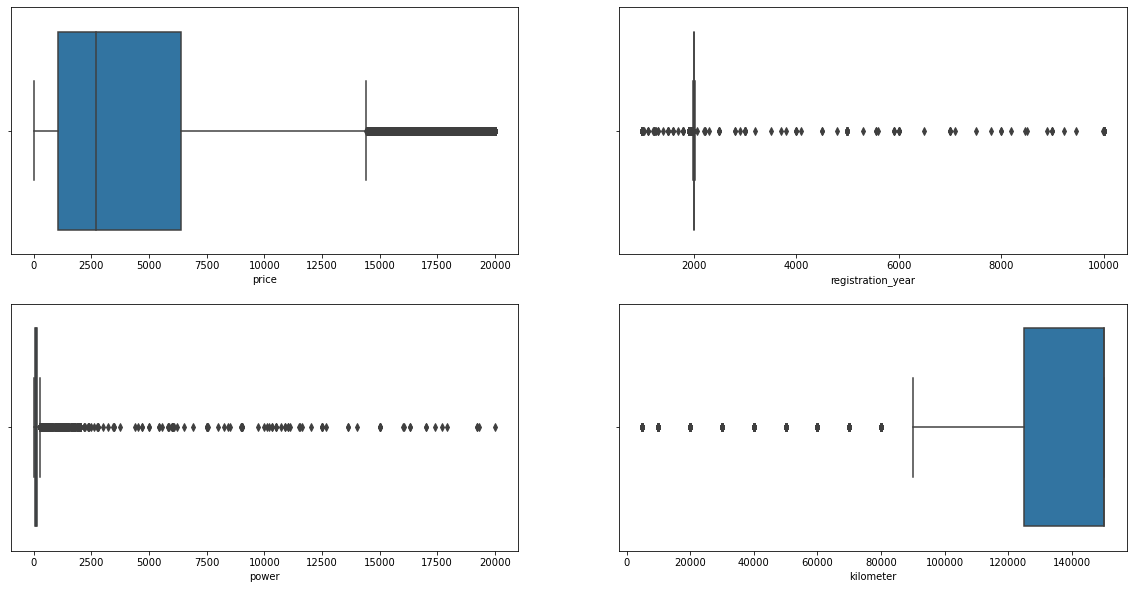

In [13]:
# построим боксплоты
fig, axis = plt.subplots(2,2, figsize=(20,10))

sns.boxplot(df['price'], ax=axis[0,0]);
sns.boxplot(df['registration_year'], ax=axis[0,1]);
sns.boxplot(df['power'], ax=axis[1,0]);
sns.boxplot(df['kilometer'], ax=axis[1,1]);

#### Изучим столбец 'price'

In [14]:
# найдем уникальные значения в столбце "цена"
df['price'].sort_values().unique()

array([    0,     1,     2, ..., 19998, 19999, 20000], dtype=int64)

In [15]:
# посчитаем квантили и выведем верхнюю и нижнюю границы боксплота
Q1 = df.price.quantile(0.25)
Q3 = df.price.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR 

print('Верхняя граница:', upper)
print('Нижняя граница:', lower)

Верхняя граница: 14425.0
Нижняя граница: -6975.0


* очевидно, что автомобиль не может стоить 0, 1, 2 ... евро
* цены на б/у автомобили стартуют от 15 000 тысяч рублей, что соответствует 180 евро
* верхнюю границу стоимости оставим 15000 евро

In [16]:
# исходя из этого удалим строки с аномалиями по цене
df = df.loc[(df['price'] >= 180) & (df['price'] <= 15000)]

#### Изучим столбец 'registration_year'

In [17]:
# найдем уникальные значения в столбце "год регистрации"
df['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1234, 1300, 1400, 1500, 1600, 1602, 1800,
       1910, 1923, 1925, 1928, 1929, 1930, 1931, 1932, 1934, 1935, 1936,
       1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1948, 1949,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2066, 2200, 2290, 2500, 2800, 2900, 3000,
       3200, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5900,
       5911, 6000, 7000, 7100, 7800, 8200, 8500, 8888, 9000, 9450, 9999],
      dtype=int64)

In [18]:
# посчитаем квантили и выведем верхнюю и нижнюю границы боксплота
Q1 = df.registration_year.quantile(0.25)
Q3 = df.registration_year.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR 

print('Верхняя граница:', upper)
print('Нижняя граница:', lower)

Верхняя граница: 2019.0
Нижняя граница: 1987.0


In [19]:
# оценим количество строк с годом регистрации автомобиля меньше 1987
df[['registration_year']].query('1987 > registration_year').count()

registration_year    5484
dtype: int64

* верхнюю границу границу года регистрации ограничим 2019, после этой даты идут аномалии, хотя текущий 2023 
* если ставить нижней границей по году регистрации - 1987, то придется удалить очень много данных, что скажется на обучении модели
* практически у всех современных автомобилей средний срок службы составляет примерно 12 лет, увеличим его в 5 раз до 60 лет
* тогда нижней границей по году регистрации поставим 1959 год
* так мы избавимся от аномалий и сохраним данные

In [20]:
# удалим строки с аномалиями по годам: меньше 1959 и больше 2019
df = df.loc[(df['registration_year'] <= 2019) & (df['registration_year'] >= 1959)]

In [21]:
# самый поздний год создания анкеты в базе и скачавания базы - 2016  
data_avto[['DateCreated','DateCrawled','RegistrationYear']].max()

DateCreated         2016-04-07 00:00:00
DateCrawled         2016-04-07 14:36:58
RegistrationYear                   9999
dtype: object

In [22]:
# тогда можно удалить строки с датой регистрации авто старше 2016
df = df.loc[(df['registration_year'] <= 2016)]

#### Изучим столбец 'power'

In [23]:
# найдем уникальные значения в столбце "мощность"
df['power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    33,    34,    35,    36,
          37,    38,    39,    40,    41,    42,    43,    44,    45,
          46,    47,    48,    49,    50,    51,    52,    53,    54,
          55,    56,    57,    58,    59,    60,    61,    62,    63,
          64,    65,    66,    67,    68,    69,    70,    71,    72,
          73,    74,    75,    76,    77,    78,    79,    80,    81,
          82,    83,    84,    85,    86,    87,    88,    89,    90,
          91,    92,    93,    94,    95,    96,    97,    98,    99,
         100,   101,   102,   103,   104,   105,   106,   107,   108,
         109,   110,   111,   112,   113,   114,   115,   116,   117,
         118,   119,   120,   121,   122,   123,   124,   125,   126,
         127,   128,

In [24]:
# посчитаем квантили и выведем верхнюю и нижнюю границы боксплота
Q1 = df.power.quantile(0.25)
Q3 = df.power.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR 

print('Верхняя граница:', upper)
print('Нижняя граница:', lower)

Верхняя граница: 245.0
Нижняя граница: -35.0


* обработку этого столбца проведем на основе данных из интернета и здравого смысла
* Lamborghini Carbonado GT Mansory самый мощный из серийных легковых автомобилей - 1600 л.с.
* Запорожец ЗАЗ 968 - 42 л.с.

In [25]:
# исходя из этого удалим строки с аномалиями по мощности 
df = df.loc[(df['power'] <= 1600) & (df['power'] >= 42)]

#### Изучим столбец 'kilometer'

* обработку столбца "kilometer" пока отложим, т.к. в реальности пробег может быть от нуля до бесконечности

In [26]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [27]:
df.shape

(277135, 10)

In [28]:
print('Исходные данные:' , len(data_avto))
print('Очищенные данные:', len(df))
print(f'Удалили {((len(data_avto) - len(df))/(len(data_avto))):.2%} от исходных данных')

Исходные данные: 354369
Очищенные данные: 277135
Удалили 21.79% от исходных данных


#### Выводы

1. Числовые данные очищены от выбросов и аномалий
2. Удалили 21.79% объектов от исходных данных, что конечно же много, значит оставшиеся данные нужно сохранить.

### 1.6 Оценим количество пропусков в процентном отношении

In [29]:
# пропуски в процентах
def lost(data):
    if data.isna().sum().sum()>0:
        display(
            (round(data.isna().mean()*100,3))
            .to_frame()
            .rename(columns = {0:'Пропуски'})
            .query('Пропуски > 0')
            .sort_values(by = 'Пропуски', ascending = False)
            .style.background_gradient('coolwarm')
        )
    else:
        print('Пропусков нет')

In [30]:
lost(df)

,Пропуски
repaired,14.627000
fuel_type,5.233000
model,3.678000
vehicle_type,3.676000
gearbox,1.761000


* пропуски остались в категориальных признаках
* их достаточно много, чтобы просто удалить
* будем заполнять наиболее частым значением в категории или заглушкой "unknown"
* пропусков нет в столбце 'brand' его и возьмем за основу

### 1.7 Обработаем категориальные признаки

#### Изучим столбец 'brand'

In [31]:
# уникальные значения столбца 'brand'
df['brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [32]:
# количество по моделям
df['brand'].value_counts()

volkswagen        60220
opel              31359
bmw               29508
mercedes_benz     24961
audi              23139
ford              19636
renault           13465
peugeot            9192
fiat               7198
seat               5584
skoda              4653
mazda              4569
citroen            4086
smart              4002
toyota             3892
nissan             3762
hyundai            2940
volvo              2663
mini               2553
mitsubishi         2402
honda              2321
kia                1950
alfa_romeo         1910
suzuki             1881
chevrolet          1379
sonstige_autos     1358
chrysler           1120
dacia               790
subaru              598
daihatsu            582
jeep                512
saab                461
porsche             430
daewoo              399
land_rover          385
jaguar              384
lancia              370
rover               356
lada                157
trabant               8
Name: brand, dtype: int64

#### Изучим столбец 'model'

In [33]:
# изучим уникальные значения в столбце
df['model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [34]:
# rangerover' и 'range_rover' - это одна и та же модель
df[df['model'] == 'range_rover']

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
5615,14900,suv,1993,auto,182,range_rover,150000,petrol,land_rover,no
22356,2800,suv,1996,auto,224,range_rover,150000,NaN,land_rover,no
26526,5600,suv,1982,manual,125,range_rover,5000,petrol,land_rover,NaN
32216,14950,suv,1994,auto,182,range_rover,150000,petrol,land_rover,no
42698,6800,suv,2004,auto,177,range_rover,150000,gasoline,land_rover,NaN
...,...,...,...,...,...,...,...,...,...,...
321491,3600,suv,1999,auto,218,range_rover,150000,petrol,land_rover,no
340882,1500,NaN,1995,auto,224,range_rover,150000,petrol,land_rover,NaN
344294,3500,suv,1997,manual,136,range_rover,150000,gasoline,land_rover,no
345351,10999,suv,2004,auto,286,range_rover,150000,petrol,land_rover,no


In [35]:
df[df['model'] == 'rangerover']

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
27949,1050,small,1998,manual,103,rangerover,150000,petrol,rover,NaN


In [36]:
# приведем к одному типу написания
df['model'] = df['model'].replace(['rangerover'],'range_rover')

In [37]:
# количество по моделям
df['model'].value_counts()

golf                  23369
other                 18734
3er                   16414
polo                  10292
corsa                  9669
                      ...  
q3                        3
range_rover_evoque        2
serie_3                   2
gl                        2
601                       1
Name: model, Length: 248, dtype: int64

In [38]:
# найдем наиболее распространенные модели для каждого бренда
most_common_model = df.groupby('brand')['model'].agg(lambda x: x.value_counts(dropna=False).index[0]).to_dict()

In [39]:
# заполним пропуски в столбце "model" наиболее частым значениями для соответствующих брендов
df['model'] = df.apply(
    lambda row: most_common_model[row['brand']] 
    if pd.isna(row['model']) 
    else row['model'], axis=1)

In [40]:
# проверим
lost(df)

,Пропуски
repaired,14.627000
fuel_type,5.233000
vehicle_type,3.676000
gearbox,1.761000
model,0.490000


In [41]:
# предположим, что у оставшихся брендов с пропусками нет подходящего обозначения модели и эти пропуски заменим значением "other"
df['model'].fillna('other', inplace=True)

#### Изучим столбец 'vehicle_type'

In [42]:
# найдем уникальные значения в столбце "тип ТС"
df['vehicle_type'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

In [43]:
# количество по типам ТС
df['vehicle_type'].value_counts()

sedan          78338
small          66975
wagon          56022
bus            24767
convertible    16726
coupe          12863
suv             8972
other           2285
Name: vehicle_type, dtype: int64

In [44]:
# найдем наиболее расспространенный тип транспортного средства для каждой модели
most_common_vehicle_type = df.groupby('model')['vehicle_type'].agg(lambda x: x.value_counts(dropna=False).index[0]).to_dict()

In [45]:
# заполним пропуски в столбце "vehicle_type" наиболее частыми значениями для соответствующих моделей
df['vehicle_type'] = df.apply(
    lambda row: most_common_vehicle_type[row['model']] 
    if pd.isna(row['vehicle_type']) 
    else row['vehicle_type'], axis=1
)

In [46]:
# проверим
lost(df)

,Пропуски
repaired,14.627000
fuel_type,5.233000
gearbox,1.761000


#### Изучим столбец 'fuel_type'

In [47]:
# найдем уникальные значения в столбце fuel_type
df['fuel_type'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

In [48]:
# количество по типам топлива
df['fuel_type'].value_counts()

petrol      177845
gasoline     79476
lpg           4587
cng            477
hybrid         164
other           54
electric        30
Name: fuel_type, dtype: int64

Тип топлива "petrol" и "gasoline" - это бензин, поэтому заменим значения на "petrol"

In [49]:
df['fuel_type'] = df['fuel_type'].replace(['gasoline'],'petrol')

In [50]:
# найдем наиболее расспространенный тип топлива для каждого транспортного средства
most_common_fuel_type = df.groupby('vehicle_type')['fuel_type'].agg(lambda x: x.value_counts(dropna=False).index[0]).to_dict()

In [51]:
# заполним пропуски в столбце "fuel_type" наиболее частыми значениями для соответствующего ТС
df['fuel_type'] = df.apply(
    lambda row: most_common_fuel_type[row['vehicle_type']] 
    if pd.isna(row['fuel_type']) 
    else row['fuel_type'], axis=1
)

In [52]:
# проверим
lost(df)

,Пропуски
repaired,14.627000
gearbox,1.761000


#### Изучим столбец 'gearbox'

In [53]:
# найдем уникальные значения в столбце gearbox
df['gearbox'].sort_values().unique()

array(['auto', 'manual', nan], dtype=object)

In [54]:
# количество по типу трансмиссии
df['gearbox'].value_counts()

manual    220652
auto       51604
Name: gearbox, dtype: int64

In [55]:
# определим самый частый тип трансписсии для типов ТС
most_common_gearbox = df.groupby('vehicle_type')['gearbox'].agg(lambda x: x.value_counts(dropna=False).index[0]).to_dict()

In [56]:
# заполним пропуски в столбце "gearbox" наиболее частыми значениями для соответствующих типов ТС
df['gearbox'] = df.apply(
    lambda row: most_common_gearbox[row['vehicle_type']] 
    if pd.isna(row['gearbox']) 
    else row['gearbox'], axis=1
)

In [57]:
# проверим
lost(df)

,Пропуски
repaired,14.627000


#### Изучим столбец 'repaired'

In [58]:
# проверим уникакльные значения стоолбца "repaired"
df['repaired'].sort_values().unique()

array(['no', 'yes', nan], dtype=object)

In [59]:
# количество по признаку ремонт
df['repaired'].value_counts()

no     209350
yes     27249
Name: repaired, dtype: int64

In [60]:
# удалять почти 15% данных не будем, заполним пропуски значением "unknown"
df['repaired'].fillna('unknown', inplace=True)

In [61]:
# проверим
lost(df)

Пропусков нет


In [62]:
# общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277135 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              277135 non-null  int64 
 1   vehicle_type       277135 non-null  object
 2   registration_year  277135 non-null  int64 
 3   gearbox            277135 non-null  object
 4   power              277135 non-null  int64 
 5   model              277135 non-null  object
 6   kilometer          277135 non-null  int64 
 7   fuel_type          277135 non-null  object
 8   brand              277135 non-null  object
 9   repaired           277135 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.3+ MB


### Выводы

1. Исходный данные содержали большое количество пропусков, аномалии и выбросы.
2. Все аномалии в числовых признаках обработаны (удалены).
3. Пропуски в категориальных признах заполнены модой или значением "unknown".
4. Исходные данные содержали 354369 строк, после очистки данных - 277135.
5. Удалили 21.79% от исходных данных.

## 2. Подготовка данных и обучение моделей

* LinearRegression
* RandomForestRegressorr
* CatBoostRegressor
* LGBMRegressor

### 2.1 Разделим выборки и извлечем признаки
* **train** - обучающая выборка (**75%** исходных данных)
* **test** - тестовая выборка (**25%** исходных данных)

In [63]:
features = df.drop(['price'], axis=1)                           # признаки
target = df['price']                                            # выделим целевой признак

# разделим на тренировочную - 75% и тестовую - 25% выборки
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

In [64]:
print('\033[1m'+ 'Обучающая выборка'+'\033[0m')
print ('Признаки:',X_train.shape, '\n', 'Целевой признак:', y_train.shape, sep='')
print('='*30)
print('\033[1m'+ 'Тестовая выборка'+'\033[0m')
print ('Признаки:',X_test.shape, '\n', 'Целевой признак:', y_test.shape, sep='')

Обучающая выборка
Признаки:(207851, 9)
Целевой признак:(207851,)
Тестовая выборка
Признаки:(69284, 9)
Целевой признак:(69284,)


### 2.2 Извлечем категориальные и числовые признаки

In [65]:
# категориальные признаки 
cat_features = X_train.select_dtypes(include='object').columns
cat_features

Index(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'], dtype='object')

In [66]:
# численные признаки
num_features = X_train.select_dtypes(exclude='object').columns
num_features

Index(['registration_year', 'power', 'kilometer'], dtype='object')

### 2.3 Модель "Linear Regression"

In [67]:
# признаки для Линейной регрессии
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

In [68]:
# закодируем категориальные признаки и масштабируем числовые 
transformer_lr = make_column_transformer((StandardScaler(), num_features), 
                                         (OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
                                         remainder = 'passthrough', verbose_feature_names_out=False
                                        )

In [69]:
# создадим модель
model_lr = make_pipeline(transformer_lr, LinearRegression())

In [70]:
# определяем параметры для перебора в GridSearchCV
parametrs_lr  = {} 

In [71]:
%%time
# передаем модель, параметры и оценку в GridSearchCV
lr  = GridSearchCV(
    model_lr,
    param_grid = parametrs_lr,
    scoring='neg_root_mean_squared_error'
)
# обучим на тренировочных данных
lr.fit(X_train_lr, y_train)
# найдем лучший RMSE
rmse_lr = lr.best_score_*-1

print('\033[1m'+ 'Модель "Linear Regression"'+'\033[0m')
print('\033[1m'+'RMSE:'+'\033[0m', rmse_lr)
print('='*30)

Модель "Linear Regression"
RMSE: 2276.2089244343506
CPU times: total: 21.9 s
Wall time: 22.3 s


### 2.4 Модель "Random Forest Regressor"

In [72]:
# признаки для Регрессии случайного леса 
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [73]:
# закодируем категориальные признаки и масштабируем числовые
transformer_rf = make_column_transformer((StandardScaler(), num_features),
                                         (OrdinalEncoder (handle_unknown='use_encoded_value', unknown_value=-1), cat_features),
                                         remainder = 'passthrough', verbose_feature_names_out=False)

In [74]:
# создадим модель
model_rf = make_pipeline(transformer_rf, RandomForestRegressor(random_state=RANDOM_STATE))

In [75]:
# определяем параметры для RandomizedSearchCV
parametrs_rf = {
    'randomforestregressor__n_estimators': range(50, 251, 50),
    'randomforestregressor__max_depth': range(2, 15),
    'randomforestregressor__min_samples_split': (2, 3, 4),
    'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
               }

In [76]:
%%time
# обучим модель и найдем лучшие параметры
rf = RandomizedSearchCV(
    model_rf, 
    param_distributions=parametrs_rf, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf.fit(X_train_rf, y_train)

rf_best_params = rf.best_params_
print(f'Лучшие параметры для Random Forest Regressor: {rf_best_params}')
print('='*60)

rmse_rf = rf.best_score_*-1
print('\033[1m'+ 'Модель "Random Forest Regressor"'+'\033[0m')
print('\033[1m'+'RMSE:'+'\033[0m', rmse_rf)
print('='*30)

Лучшие параметры для Random Forest Regressor: {'randomforestregressor__n_estimators': 250, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__min_samples_leaf': 3, 'randomforestregressor__max_depth': 12}
Модель "Random Forest Regressor"
RMSE: 1486.8701319706415
CPU times: total: 1min 16s
Wall time: 11min 35s


**Лучшие параметры для Random Forest Regressor:** 
- 'randomforestregressor__n_estimators': 250
- 'randomforestregressor__min_samples_split': 4
- 'randomforestregressor__min_samples_leaf': 3,
- 'randomforestregressor__max_depth': 12}

**Время подбора параметров:**
- CPU times: total: 1min 29s
- Wall time: 12min 18s

### 2.5 Модель "Cat Boost Regressor"

In [77]:
# признаки для Регрессии КэтБуст
X_train_cbr = X_train.copy()
X_test_cbr = X_test.copy()

In [78]:
# создадим модель и передадим ей категориальные признаки
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE, 
                              verbose=False, 
                              cat_features=['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'model', 'repaired']) 

In [79]:
# параметры для подбора
parameters_cbr = [{'learning_rate':[0.1, 0.5, 0.8],
               'depth':[6,8,10],
               'iterations':[30, 50, 100],
               'verbose':[False]}]

In [80]:
%%time
# подберем лучшие параметры для модели CatBoostRegressor
grid_cbr = GridSearchCV(
    estimator=model_cbr,
    param_grid = parameters_cbr,
    cv = 2,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_cbr.fit(X_train_cbr, y_train)
rmse_cbr = grid_cbr.best_score_* -1
print('\033[1m'+ 'Модель "CatBoost Regressor"'+'\033[0m')
print('\033[1m'+'RMSE:'+'\033[0m', rmse_cbr)
print("Лучшие параметры для Cat Boost Regressor:\n", grid_cbr.best_params_)
print('='*75)

### 2.6 Модель "LightGBM Regressor"

In [81]:
# признаки для Регресси ЛайтГМБ 
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

In [82]:
# изменим тип категориальных признаков с object на category для LightGBM в обучающей выбрке
for i in X_train_lgb.columns:
    column_type = X_train_lgb[i].dtype
    if column_type == 'object':
        X_train_lgb[i] = X_train_lgb[i].astype('category')

In [83]:
# создадим модель
model_lgb = lgb.LGBMRegressor(random_state=RANDOM_STATE) 

In [84]:
# параметры для подбора
parameters_lgb = {'n_estimators': [100, 500, 1000],
                  'num_leaves':[31, 100, 200],
                  'learning_rate':[0.1, 0.3, 0.5]}

In [85]:
%%time
# подберем лучшие параметры для модели LGBMRegressor
grid_lgb = GridSearchCV(estimator=model_lgb,
                          param_grid=parameters_lgb,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=3)

grid_lgb.fit(X_train_lgb, y_train)
rmse_lgb = grid_lgb.best_score_* -1
print('\033[1m'+ 'Модель "LightGBM Regressor"'+'\033[0m')
print('\033[1m'+'RMSE:'+'\033[0m', rmse_lgb)
print("Лучшие параметры для Cat Boost Regressor:\n", grid_lgb.best_params_)
print('='*30)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END learning_rate=0.1, n_estimators=100, num_leaves=31;, score=-1393.657 total time=   0.4s
[CV 2/3] END learning_rate=0.1, n_estimators=100, num_leaves=31;, score=-1390.528 total time=   0.4s
[CV 3/3] END learning_rate=0.1, n_estimators=100, num_leaves=31;, score=-1375.658 total time=   0.3s
[CV 1/3] END learning_rate=0.1, n_estimators=100, num_leaves=100;, score=-1350.762 total time=   0.9s
[CV 2/3] END learning_rate=0.1, n_estimators=100, num_leaves=100;, score=-1351.632 total time=   1.1s
[CV 3/3] END learning_rate=0.1, n_estimators=100, num_leaves=100;, score=-1337.746 total time=   1.0s
[CV 1/3] END learning_rate=0.1, n_estimators=100, num_leaves=200;, score=-1333.586 total time=   1.3s
[CV 2/3] END learning_rate=0.1, n_estimators=100, num_leaves=200;, score=-1332.292 total time=   1.4s
[CV 3/3] END learning_rate=0.1, n_estimators=100, num_leaves=200;, score=-1319.637 total time=   1.5s
[CV 1/3] END learning_ra

## 3. Сравнение моделей

### 3.1 Сравним RMSE моделей на обучающей выборке

In [86]:
# таблица RMSE моделей на обучающей выборке
index_result =['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LightGBMRegressor']
data_result = {'RMSE на обучающей выборке':[rmse_lr, rmse_rf, rmse_cbr, rmse_lgb]}

result = pd.DataFrame(data=data_result, index=index_result)
result

,RMSE на обучающей выборке
LinearRegression,2276.208924
RandomForestRegressor,1486.870132
CatBoostRegressor,1394.865711
LightGBMRegressor,1316.613563


### Выводы

1. Самое быстрый подбор параметров у модели LinearRegression, но у неё и худший RMSE (хотя и < 2500, что в пределах ТЗ).
2. Самый долгий подбор параметров у модели RandomForestRegressor - 12 мин, при этом показатель RMSE примерно в 1,5 раза лучше, чем у LinearRegression.
3. Для модели CatBoostRegressor подбор парметров составил недолгие 2,5 минуты, что в 2,5 раз быстрее, чем LightGBMRegressor - 6,5 минут, а RMSE - 1394.
4. Лучший паказатель RMSE на обучающей выборке у модели LightGBMRegressor - 1316.

### 3.2 Сравним RMSE моделей на тестовой выборке 

#### Модель "Linear Regression"

In [87]:
%%time
# найдем время обучения модели
model_lr.fit(X_train_lr, y_train)

CPU times: total: 4.91 s
Wall time: 4.93 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['registration_year', 'power', 'kilometer'], dtype='object')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [88]:
%%time
# получим предсказания для Линейной регрессии на тестовой выборке  
predict_test_lr = model_lr.predict(X_test_lr)
# найдем RMSE
test_rmse_lr = mean_squared_error(y_test, predict_test_lr, squared=False)

print('\033[1m'+ 'Модель "Linear Regression"'+'\033[0m')
print('\033[1m'+'RMSE на тестовой выборке:'+'\033[0m', test_rmse_lr)
print('='*60)

Модель "Linear Regression"
RMSE на тестовой выборке: 2257.456476600245
CPU times: total: 93.8 ms
Wall time: 107 ms


#### Модель "Random Forest Regressor"

In [89]:
%%time
# создадим и обучим модель с лучшими параметрами
model_rf = make_pipeline(
    transformer_rf,
    RandomForestRegressor(
        random_state=RANDOM_STATE, 
        n_estimators=250, max_depth=12, 
        min_samples_split=4, 
        min_samples_leaf=3
    )
)

# найдем время обучения модели с лучшими параметрами
model_rf.fit(X_train_rf, y_train)

CPU times: total: 1min 12s
Wall time: 1min 12s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['registration_year', 'power', 'kilometer'], dtype='object')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=12, min_samples_leaf=3,
                                       min_samples_split=4, n_

In [90]:
%%time
# получим предсказания для Регрессии Случайного Леса на тестовой выборке  
predict_test_rf = model_rf.predict(X_test_rf)

# найдем RMSE
test_rmse_rf = mean_squared_error(y_test, predict_test_rf, squared=False)
print('\033[1m'+ 'Модель "Random Forest Regressor"'+'\033[0m')
print('\033[1m'+'RMSE на тестовой выборке:'+'\033[0m', test_rmse_rf)
print('='*60)

Модель "Random Forest Regressor"
RMSE на тестовой выборке: 1488.5935328744272
CPU times: total: 2.25 s
Wall time: 2.23 s


#### Модель "Cat Boost Regressor"

In [91]:
%%time
# создадим и обучим модель с лучшими параметрами, передадим ей категориальные признаки
best_model_cbr = CatBoostRegressor(random_state=RANDOM_STATE,
                                   depth=10,
                                   iterations=100,
                                   learning_rate=0.5,
                                   verbose=False,
                                   cat_features=['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'model', 'repaired']
                                  )
best_model_cbr.fit(X_train_cbr, y_train)

CPU times: total: 58.5 s
Wall time: 11.6 s


In [92]:
%%time
# получим предсказания для CatBoostRegressor на тестовой выборке  
predict_test_cbr = best_model_cbr.predict(X_test_cbr)

# найдем RMSE
test_rmse_cbr = mean_squared_error(y_test, predict_test_cbr, squared=False)
print('\033[1m'+ 'Модель "Cat Boost Regressor"'+'\033[0m')
print('\033[1m'+'RMSE на тестовой выборке:'+'\033[0m', test_rmse_cbr)
print('='*60)

Модель "Cat Boost Regressor"
RMSE на тестовой выборке: 1367.159333038923
CPU times: total: 562 ms
Wall time: 239 ms


#### Модель "LightGBM Regressor"

In [93]:
# изменим тип категориальных признаков с object на category для LightGBM в тестовой выбрке
for i in X_test_lgb.columns:
    column_type = X_test_lgb[i].dtype
    if column_type == 'object':
        X_test_lgb[i] = X_test_lgb[i].astype('category')

In [94]:
%%time
# создадим модель и обучим с лучшими параметрами 
best_model_lgb = lgb.LGBMRegressor(random_state=RANDOM_STATE,
                              learning_rate=0.1,
                              n_estimators=500,
                              num_leaves=200
                             )
best_model_lgb.fit(X_train_lgb, y_train)

CPU times: total: 25 s
Wall time: 3.42 s


LGBMRegressor(n_estimators=500, num_leaves=200, random_state=42)

In [95]:
%%time
# получим предсказания для для LightGBM на тестовой выбрке
predict_test_lgb = best_model_lgb.predict(X_test_lgb)

# найдем RMSE
test_rmse_lgb = mean_squared_error(y_test, predict_test_lgb, squared=False)
print('\033[1m'+ 'Модель "Cat Boost Regressor"'+'\033[0m')
print('\033[1m'+'RMSE на тестовой выборке:'+'\033[0m', test_rmse_lgb)
print('='*60)

Модель "Cat Boost Regressor"
RMSE на тестовой выборке: 1297.8814671871799
CPU times: total: 4.59 s
Wall time: 636 ms


## 4. Выбор лучшей модели

In [96]:
index=['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LightGBMRegressor']
data = {'RMSE на обучающей выборке':[rmse_lr, rmse_rf, rmse_cbr, rmse_lgb],
        'Подбор параметров, сек':[24.9, 738, 142, 385],
        'RMSE на тестовой выборке':[test_rmse_lr, test_rmse_rf, test_rmse_cbr, test_rmse_lgb],
        'Время обучения, сек':[4.4, 81, 16.2, 4.49],
        'Время предсказания, мсек':[150, 2560, 275, 811]}

final_result = pd.DataFrame(data=data, index=index)
final_result

,RMSE на обучающей выборке,"Подбор параметров, сек",RMSE на тестовой выборке,"Время обучения, сек","Время предсказания, мсек"
LinearRegression,2276.208924,24.9,2257.456477,4.40,150
RandomForestRegressor,1486.870132,738.0,1488.593533,81.00,2560
CatBoostRegressor,1394.865711,142.0,1367.159333,16.20,275
LightGBMRegressor,1316.613563,385.0,1297.881467,4.49,811


### Вывод

Главными критериями выбора модели для заказчика являются:
- качество предсказания, RMSE должно быть меньше 2500
- скорость предсказания
- время обучения

1. Все модели на тестовой выборке показали результат RMSE < 2500, лучшие модели:
- LightGBMRegressor        RMSE = 1297
- CatBoostRegressor        RMSE = 1367 
- RandomForestRegressor    RMSE = 1488 

2. Лучшие модели по скорости предсказания, мсек:
- LinearRegression      - 150         
- CatBoostRegressor     - 275          
- LightGBMRegressor     - 811          

3. Лучшие модели по скорости обучения, сек:
- LinearRegression    - 4,40         
- LightGBMRegressor   - 4,49         
- CatBoostRegressor   - 16,20          


Модель LinearRegression хотя и самая быстрая, но по точности предсказаний  сильно уступает остальным моделям. 

Модль RandomForestRegressor - по точности лучше LinearRegression, но довольно медленная.

Модель LightGBMRegressor далает самые точные предсказания, но уступает в скорости предсказания CatBoostRegressor - почти в 4 раза. но при этом в 4 раза быстрее учится.

Исходя из этого заказчику можно предложить **модель LightGBMRegressor** - первое место по точности и второе по скорости обучения, третье - по скорости предсказания.

## Вывод 

1. Загруженны и изученный исходные данные.
2. Проведена первичная обработка, заполнение пропусков и удаление аномалий.
3. Данные подготовлены к обучению, разделные на выборки.
4. Были изучены четыре модели, подобраны гиперпараметры на обучающей выборке.
5. Окончательная проверка моделей проведена на тестовой выборке.
6. Выбрана лучшая по точности и скорости предсказания модель - **LightGBMRegressor**